# GENIE3

In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_perturb_gt

from bengrn.base import train_classifier

from bengrn import compute_genie3, compute_scenic
from grnndata import utils as grnutils
from anndata.utils import make_index_unique
import pandas as pd
import numpy as np

import scanpy as sc

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

In [2]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var["isTF"].sum()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gem_group' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/gene' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Ele

650

In [3]:
genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [4]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())
NUM_GENES = 5000
NUM_CELLS = 1024
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 10691 renamining
filtered out 0 cells, 10691 renamining
Removed 8 genes.
startin QC
Seeing 10068 outliers (94.17% of total dataset):
done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [5]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['symbol'] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:NUM_CELLS, adata.var.index.isin(
    genes) & adata.var.highly_variable]
del subadata.varp['GRN']

In [6]:
metrics = {}

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 437.57 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.021407573859355874 
recall:  0.965822705283659 
random precision: 0.020718126571001305


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 126/128 [00:05<00:00, 23.95it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████████████████████████████████████████████████████████████████████████████| 128/128 [00:05<00:00, 22.48it/s]


Area Under Precision-Recall Curve (AUPRC):  0.035501433703408906
EPR: 3.505545716061333


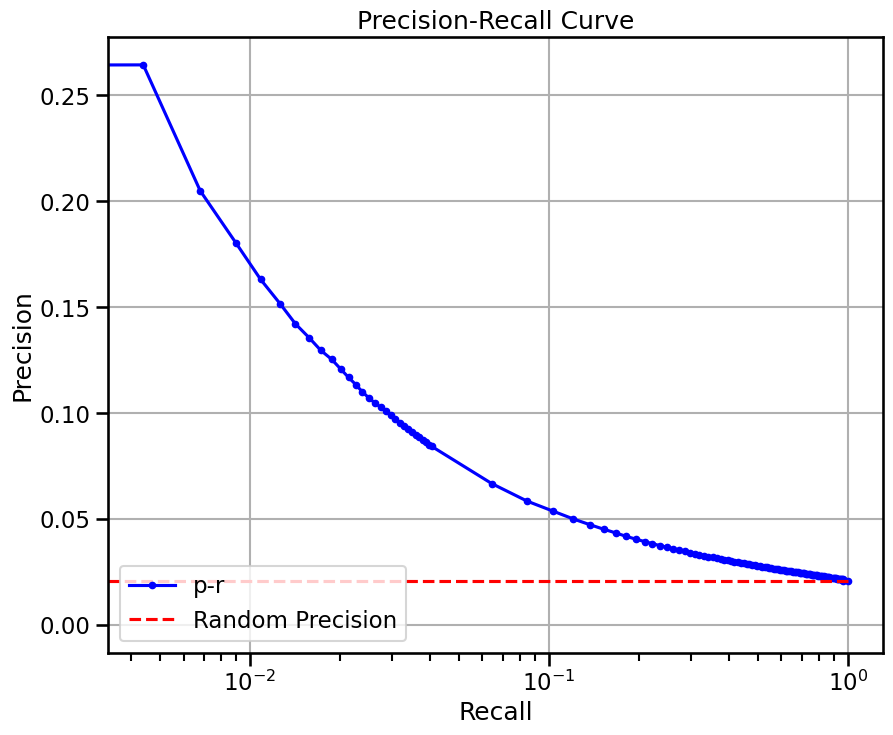

In [7]:
genie_grn = compute_genie3(subadata, nthreads=20)
genie_grn.var.index = subadata.var.index
metrics['genie3_perturb'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


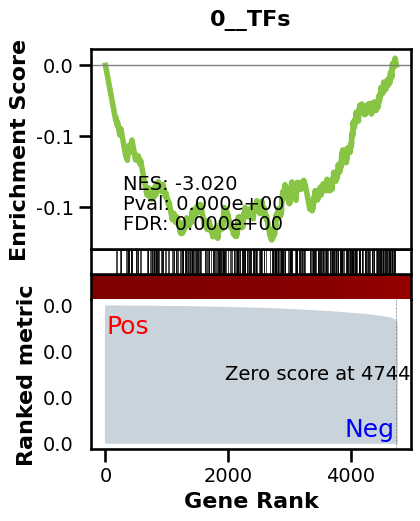

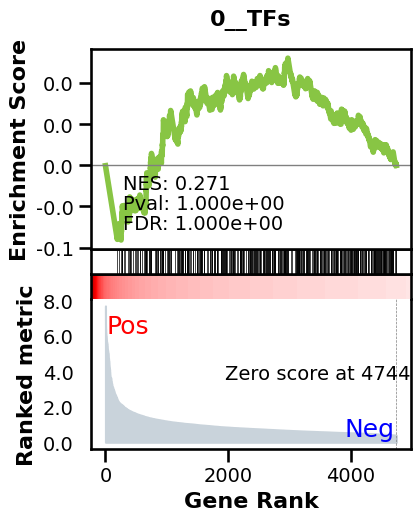

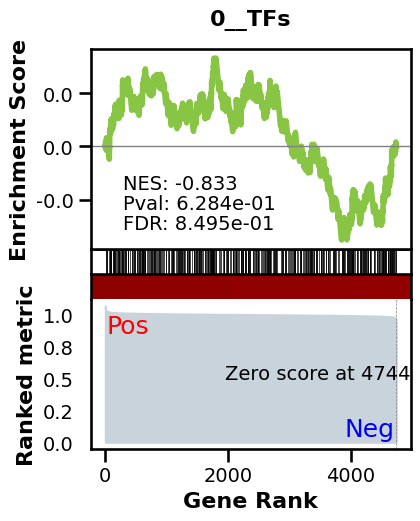

_________________________________________
TF specific enrichment
found some significant results for  17.857142857142858 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.0016906016800742395 
recall:  0.9246847469338401 
random precision: 0.0016326385571186594


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 126/128 [00:02<00:00, 51.76it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████████████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 51.66it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0018755999201671863
EPR: 4.675392050354057


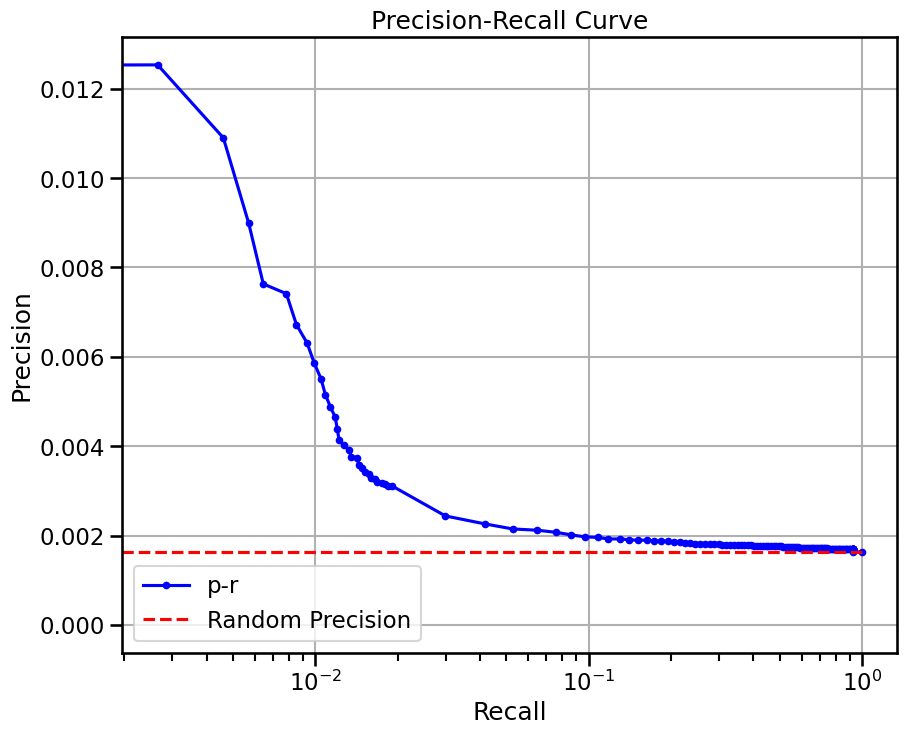

In [8]:
genie_grn.var.index = make_index_unique(genie_grn.var['symbol'].astype(str))
metrics['genie3_perturb_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 20 threads
Elapsed time: 115.69 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=20>
  _warn(f"unclosed running multiprocessing pool {self!r}",


precision:  0.015117794580555307 
recall:  0.05607212414399698 
random precision: 0.020718126571001305


 99%|█████████████████████████████████████████████████████████████████████████████████▎| 127/128 [00:05<00:00, 23.06it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████████████████████████████████████████████████████████████████████████████| 128/128 [00:05<00:00, 22.83it/s]


Area Under Precision-Recall Curve (AUPRC):  0.020833735802550143
EPR: 1.0828661631403382


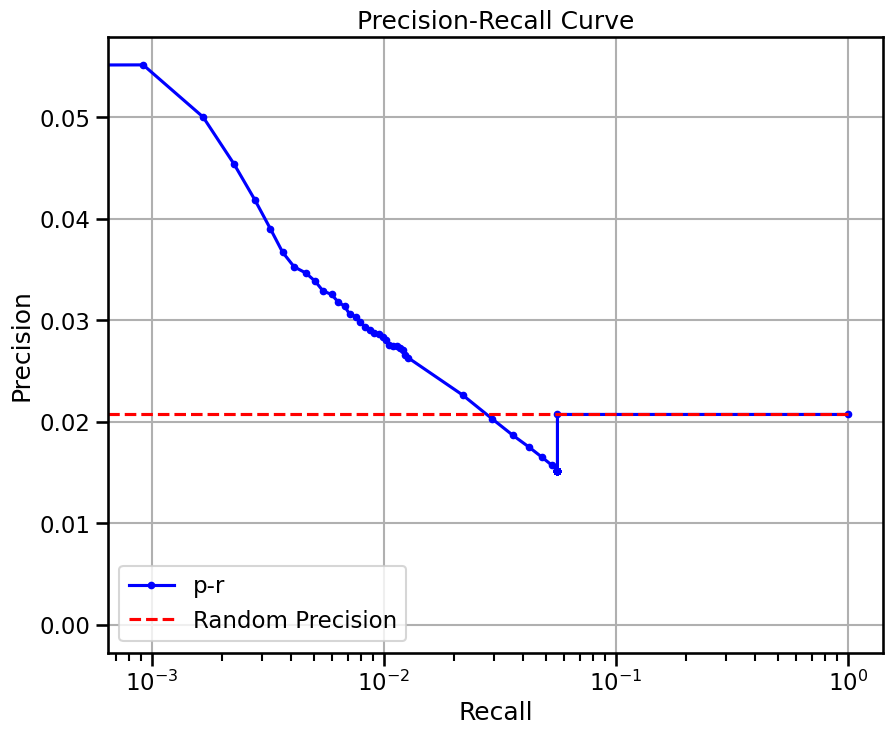

In [9]:
genie_grn = compute_genie3(subadata, nthreads=20,
                           regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var.index = subadata.var.index
metrics['genie3_tf_perturb'] = BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


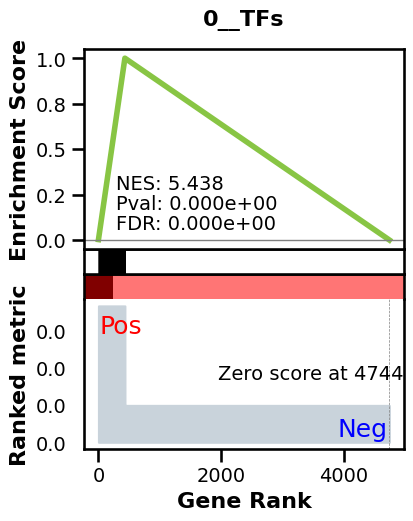

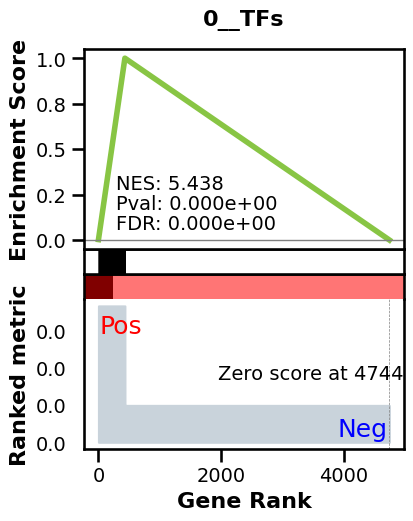

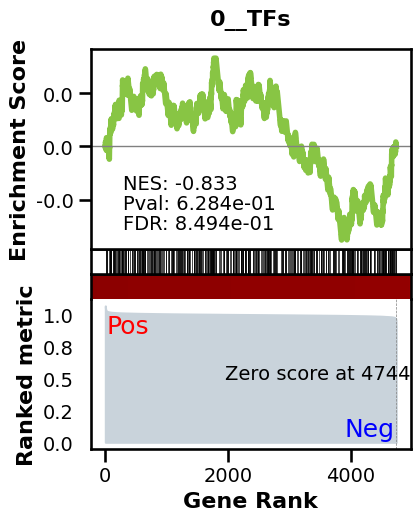

_________________________________________
TF specific enrichment
found some significant results for  7.142857142857143 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3261 genes
intersection pct: 0.687249736564805
precision:  0.008116239265915802 
recall:  0.5714861518972765 
random precision: 0.0016326385571186594


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 126/128 [00:02<00:00, 51.92it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 51.98it/s]


Area Under Precision-Recall Curve (AUPRC):  0.008180979187413328
EPR: 16.867644408414105


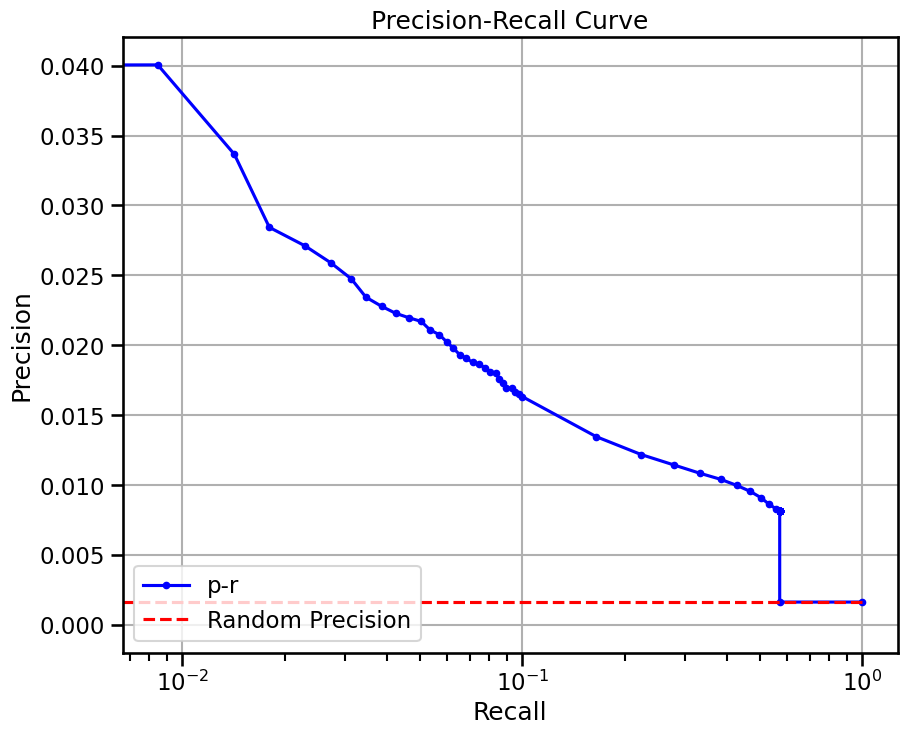

In [10]:
genie_grn.var.index = make_index_unique(genie_grn.var['symbol'].astype(str))
metrics['genie3_tf_perturb_base'] = BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

In [11]:
metrics

{'genie3_perturb': {'precision': 0.021407573859355874,
  'recall': 0.965822705283659,
  'rand_precision': 0.020718126571001305,
  'auprc': 0.035501433703408906,
  'epr': 3.505545716061333},
 'genie3_perturb_base': {'TF_enr': True,
  'significant_enriched_TFtargets': 17.857142857142858,
  'precision': 0.0016906016800742395,
  'recall': 0.9246847469338401,
  'rand_precision': 0.0016326385571186594,
  'auprc': 0.0018755999201671863,
  'epr': 4.675392050354057},
 'genie3_tf_perturb': {'precision': 0.015117794580555307,
  'recall': 0.05607212414399698,
  'rand_precision': 0.020718126571001305,
  'auprc': 0.020833735802550143,
  'epr': 1.0828661631403382},
 'genie3_tf_perturb_base': {'enriched_terms_Central': ['0__TFs',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Enteric neurons',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Tuft cells',
   'celltype.gmt__Radial glial cells',
   'celltype.gmt__Microfold cells'],
  'TF_enr': True,
  'significant_enriched_TFtargets': 7.

In [3]:
import pandas as pd

In [4]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,perturb,3.505546,0.035501,0.020718,False
1,perturb,1.082866,0.020834,0.020718,True


In [5]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,perturb,4.675392,0.001876,0.001633,17.857143,True,False
1,perturb,16.867644,0.008181,0.001633,7.142857,True,True
